In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
print('loading the dataset')

df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
X = df.values[:, :-1]
y = df.values[:, -1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=100, random_state=10)


loading the dataset
Split into Train and Test


In [3]:
#######################################
# Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    # train_const = train[:, 0].T
    train = train[:, 1:]
    test = test[:, 1:]
    train_max = train.max(axis=0)
    train_min = train.min(axis=0)
    train_normalized = (train - train_min) / (train_max - train_min)
    test_normalized = (test - train_min) / (train_max - train_min)

    # train_normalized = np.c_[train_const, train_normalized]
    return train_normalized, test_normalized


X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

In [4]:
# test
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
feature_normalization(X, X)

(array([[0. , 0. ],
        [0.5, 0.5],
        [1. , 1. ]]),
 array([[0. , 0. ],
        [0.5, 0.5],
        [1. , 1. ]]))

In [5]:
#######################################
# The square loss function
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    loss = X @ theta - y
    return 1 / X.shape[0] * (loss @ loss)

In [6]:
# test
X = np.array([[1, 4], [2, 5], [3, 6]])
y = np.array([7, 8, 10])
theta = np.array([1, 1])
compute_square_loss(X, y, theta)


2.0

In [7]:
#######################################
# The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    loss = X @ theta - y
    return 2 / X.shape[0] * (X.T @ loss)


In [8]:
# test
X = np.array([[1, 4], [2, 5], [3, 6]])
y = np.array([7, 8, 10])
theta = np.array([1, 1])
compute_square_loss_gradient(X, y, theta)


array([ -4.66666667, -12.66666667])

In [9]:
#######################################
# Gradient checker
# Getting the gradient calculation correct is often the trickiest part
# of any gradient-based optimization algorithm. Fortunately, it's very
# easy to check that the gradient calculation is correct using the
# definition of gradient.
# See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(
        X, y, theta)  # The true gradient
    num_features = theta.shape[0]
    # Initialize the gradient we approximate
    approx_grad = np.zeros(num_features)
    for i in range(num_features):
        e_i = np.zeros(num_features)
        e_i[i] = 1
        mse_plus = compute_square_loss(X, y, theta + epsilon * e_i)
        mse_minus = compute_square_loss(X, y, theta - epsilon * e_i)
        approx_grad[i] = (mse_plus - mse_minus)/(2 * epsilon)
        distance = np.linalg.norm(approx_grad - true_gradient, ord=2)
    return distance < tolerance


In [10]:
# test
theta = np.ones(X_train.shape[1])
grad_checker(X_train, y_train, theta)


True

In [11]:
#######################################
# Generic gradient checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func,
                             epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. 
    And check whether gradient_func(X, y, theta) returned the true 
    gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta)  # The true gradient
    num_features = theta.shape[0]
    # Initialize the gradient we approximate
    approx_grad = np.zeros(num_features)
    for i in range(num_features):
        e_i = np.zeros(num_features)
        e_i[i] = 1
        mse_plus = objective_func(X, y, theta + epsilon * e_i)
        mse_minus = objective_func(X, y, theta - epsilon * e_i)
        approx_grad[i] = (mse_plus - mse_minus)/(2 * epsilon)
        distance = np.linalg.norm(approx_grad - true_gradient, ord=2)
    return distance < tolerance


In [12]:
# test
theta = np.ones(X_train.shape[1])
grad_checker(X_train, y_train, theta)


True

In [13]:
#######################################
# Batch gradient descent
def batch_grad_descent(X, y, alpha, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features)
                          )  # Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  # Initialize loss_hist
    theta = np.zeros(num_features)  # Initialize theta

    for i in range(num_step + 1):
        theta_hist[i, ] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        if grad_check:
            assert grad_checker(X, y, theta)
        theta = theta - compute_square_loss_gradient(X, y, theta) * alpha
    return theta_hist, loss_hist


C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: RuntimeWarning: overflow encountered in matmul
  return 1 / X.shape[0] * (loss @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:15: RuntimeWarning: invalid value encountered in matmul
  loss = X @ theta - y
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: RuntimeWarning: overflow encountered in matmul
  return 1 / X.shape[0] * (loss @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:15: RuntimeWarning: invalid value encountered in matmul
  loss = X @ theta - y


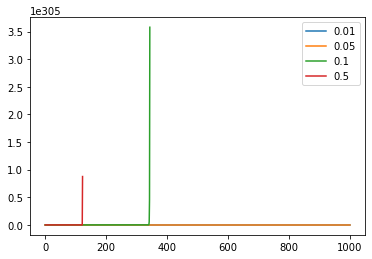

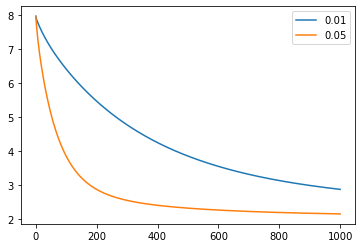

In [14]:
# plot batch_grad_descent
def step_size_plot(X, y, step_size_list):
    step_size = step_size_list
    for alpha in step_size:
        _, loss_hist = batch_grad_descent(X, y, alpha)
        plt.plot(loss_hist, label=alpha)
    plt.legend()
    plt.show()


step_size_plot(X_train, y_train, step_size_list=[.01, .05, 0.1, 0.5])
step_size_plot(X_train, y_train, step_size_list=[.01, .05])


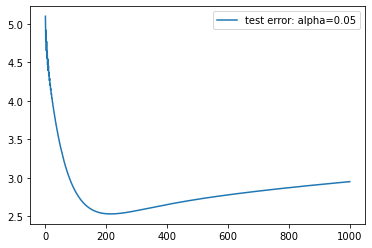

In [15]:
theta_loss, loss_hist = batch_grad_descent(X_train, y_train, alpha=.05)
test_error = []
for theta in theta_loss:
    test_error.append(compute_square_loss(X_test, y_test, theta))
plt.plot(range(len(theta_loss)), test_error, label="test error: alpha=0.05")
plt.legend()
plt.show()


In [16]:
#######################################
# The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    mseg = compute_square_loss_gradient(X, y, theta)
    return mseg + 2 * lambda_reg * theta


In [17]:
#######################################
# Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features)  # Initialize theta
    theta_hist = np.zeros((num_step+1, num_features))  # Initialize theta_hist
    loss_hist = np.zeros(num_step+1)  # Initialize loss_hist

    for i in range(num_step + 1):
        theta_hist[i, ] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta = theta - \
            compute_regularized_square_loss_gradient(
                X, y, theta, lambda_reg) * alpha
    return theta_hist, loss_hist


C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: RuntimeWarning: overflow encountered in matmul
  return 1 / X.shape[0] * (loss @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: RuntimeWarning: overflow encountered in matmul
  return 1 / X.shape[0] * (loss @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:15: RuntimeWarning: invalid value encountered in matmul
  loss = X @ theta - y
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3939161530.py:17: RuntimeWarning: overflow encountered in multiply
  return mseg + 2 * lambda_reg * theta


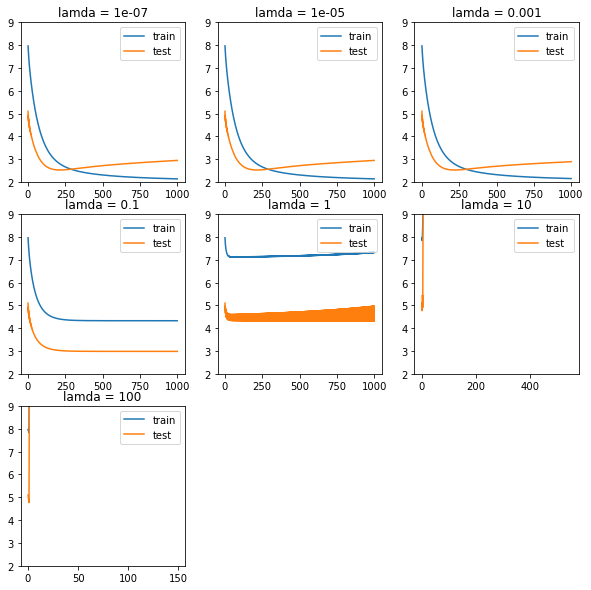

In [18]:
# detect overfitting
fig = plt.figure(figsize=(10, 10))
lambda_reg_list = [1e-7, 1e-5, 1e-3, 1e-1, 1, 10, 100]
for i, lambda_reg in enumerate(lambda_reg_list):
    test_loss = []
    theta_hist, loss_hist = regularized_grad_descent(
        X_train, y_train, lambda_reg=lambda_reg)
    for theta in theta_hist:
        test_loss.append(compute_square_loss(X_test, y_test, theta))
    plt.subplot(3, 3, i+1)
    plt.plot(range(len(loss_hist)), loss_hist, label='train')
    plt.plot(range(len(test_loss)), test_loss, label='test')
    plt.ylim([2,9])
    plt.legend()
    plt.title(f"lamda = {lambda_reg}")
plt.show()

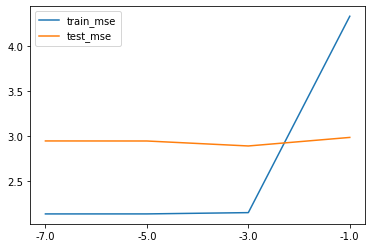

In [19]:
# select lambda
lambda_reg_list = [1e-7, 1e-5, 1e-3, 1e-1]
train_mse = []
test_mse = []
for lambda_reg in lambda_reg_list:
    theta_hist, loss_hist = regularized_grad_descent(
        X_train, y_train, alpha=0.05, lambda_reg=lambda_reg)
    train_mse.append(loss_hist[-1])
    test_mse.append(compute_square_loss(X_test, y_test, theta_hist[-1]))
plt.plot(train_mse, label='train_mse')
plt.plot(test_mse, label='test_mse')
plt.xticks(range(len(lambda_reg_list)), np.log10(lambda_reg_list))
plt.legend()
plt.show()

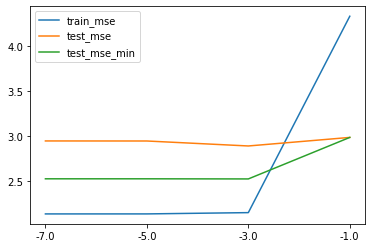

In [20]:
# early stop
lambda_reg_list = [1e-7, 1e-5, 1e-3, 1e-1]
train_mse = []
test_mse = []
test_mse_min = []
for lambda_reg in lambda_reg_list:
    theta_hist, loss_hist = regularized_grad_descent(
        X_train, y_train, alpha=0.05, lambda_reg=lambda_reg)
    test_error = []
    for theta in theta_hist:
        test_error.append(compute_square_loss(X_test, y_test, theta))
    train_mse.append(loss_hist[-1])
    test_mse.append(compute_square_loss(X_test, y_test, theta_hist[-1]))
    test_mse_min.append(np.min(test_error))
plt.plot(train_mse, label='train_mse')
plt.plot(test_mse, label='test_mse')
plt.plot(test_mse_min, label='test_mse_min')
plt.xticks(range(len(lambda_reg_list)), np.log10(lambda_reg_list))
plt.legend()
plt.show()

In [21]:
from sklearn.utils import shuffle
#######################################
# Stochastic gradient descent


def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features)  # Initialize theta

    # Initialize theta_hist
    theta_hist = np.zeros((num_epoch, num_instances, num_features))
    loss_hist = np.zeros(num_epoch)  # Initialize loss_hist

    for i in range(num_epoch):
        theta_hist[i, ] = theta
        loss_hist[i] = compute_square_loss(
            X, y, theta) + lambda_reg * (theta.T @ theta)
        if alpha == '0.1/sqrt(t)':
            step_size = 0.1 / np.sqrt(i + 1)
        elif alpha == '0.1/t':
            step_size = 0.1 / (i + 1)
        elif alpha == '0.001/sqrt(t)':
            step_size = 0.001 / np.sqrt(i + 1)
        elif alpha == '0.001/t':
            step_size = 0.001 / (i + 1)
        else:
            step_size = alpha
        X, y = shuffle(X, y, random_state=0)
        for j in range(num_instances):
            Xi = np.reshape(X[j], (-1, X[j].shape[0]))
            yi = np.reshape(y[j], 1)
            theta = theta - step_size * \
                compute_regularized_square_loss_gradient(Xi, yi, theta, lambda_reg)
            theta_hist[i, j, ] = theta
    return theta_hist, loss_hist


C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: RuntimeWarning: overflow encountered in matmul
  return 1 / X.shape[0] * (loss @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/1045660450.py:36: RuntimeWarning: overflow encountered in matmul
  X, y, theta) + lambda_reg * (theta.T @ theta)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/2267292107.py:16: RuntimeWarning: overflow encountered in multiply
  return 2 / X.shape[0] * (X.T @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:15: RuntimeWarning: invalid value encountered in matmul
  loss = X @ theta - y
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/2267292107.py:16: RuntimeWarning: invalid value encountered in matmul
  return 2 / X.shape[0] * (X.T @ loss)
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/1045660450.py:51: RuntimeWarning: invalid value encountered in subtract
  theta = theta - step_size * \
C:\Users\siyon\AppData\Local\Temp/ipykernel_59456/3402699321.py:16: Ru

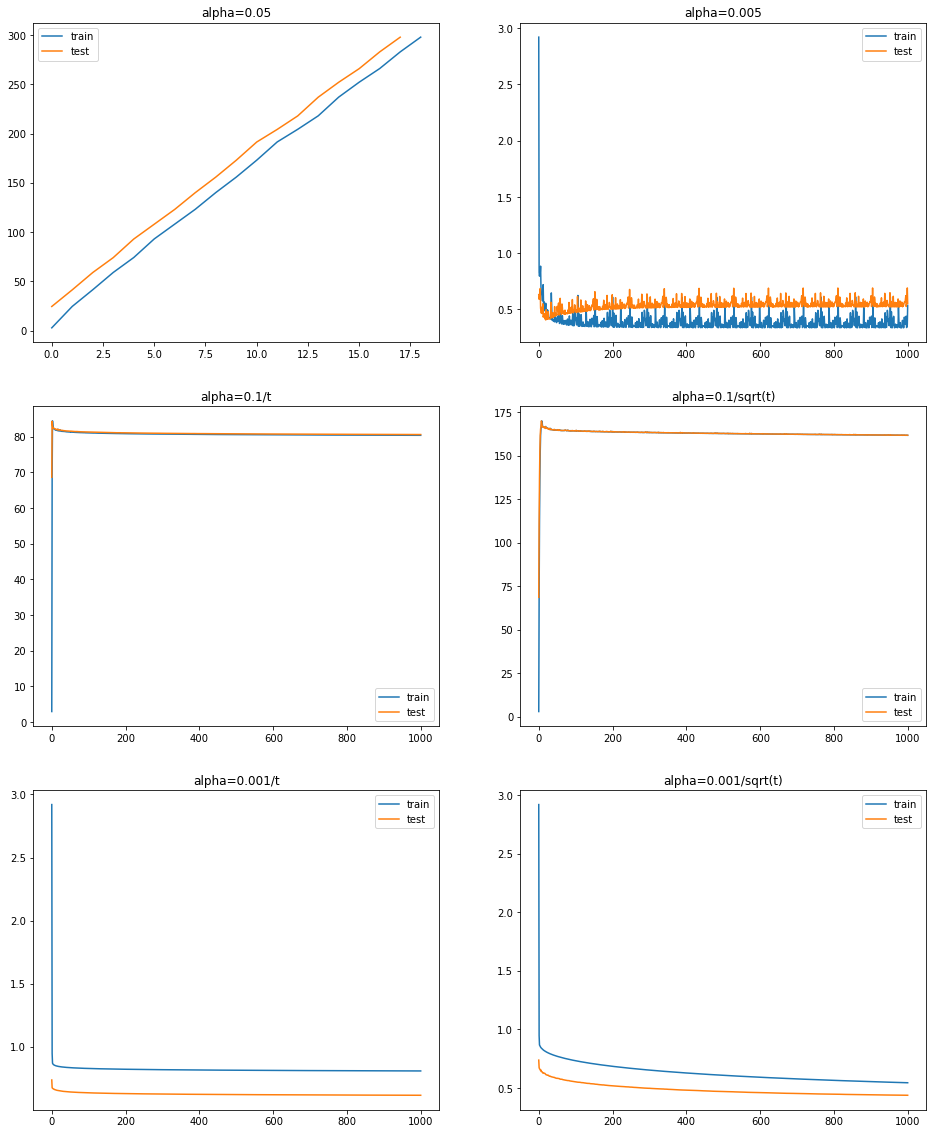

In [23]:
# choose step size
lambda_reg = 0.001
alphas = [0.05, 0.005, '0.1/t', '0.1/sqrt(t)', '0.001/t', '0.001/sqrt(t)'] #
fig = plt.figure(figsize=(16, 20))
for i, alpha in enumerate(alphas):
  plt.subplot(3, 2, i+1)
  train_theta_hist, train_loss_hist = stochastic_grad_descent(X_train, y_train, alpha, lambda_reg)
  plt.plot(np.log10(train_loss_hist).T, label='train')
  test_loss_hist = np.zeros(1000)
  # test_loss_hist = np.zeros((1000, 100))
  for j, thetas in enumerate(train_theta_hist):
    # for k, theta in enumerate(thetas):
    #   test_loss_hist[j,k] = compute_square_loss(X_test, y_test, theta) \
    #   + lambda_reg * (theta.T @ theta)
    test_loss_hist[j] = compute_square_loss(X_test, y_test, thetas[-1]) \
      + lambda_reg * (thetas[-1].T @ thetas[-1])
  plt.plot(np.log10(test_loss_hist).T, label='test')
  plt.title(f"alpha={alpha}")
  plt.legend()
plt.show()

In [24]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [25]:
def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]
X_train, y_train = sub_sample(100, X_train, y_train)

In [26]:
def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    score = np.sum(y_pred != y) / X.shape[0]
    return score

In [27]:
# test
clf = SGDClassifier(loss='log', max_iter=1000,
                    tol=1e-3,
                    penalty='l1', alpha=0.01,
                    learning_rate='invscaling',
                    power_t=0.5,
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)
assert round(classification_error(clf, X_test, y_test),13) \
    == round(1 - clf.score(X_test, y_test), 13)


-- Epoch 1
Norm: 0.32, NNZs: 375, Bias: -0.004601, T: 100, Avg. loss: 0.170869
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 370, Bias: -0.002903, T: 200, Avg. loss: 0.080544
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 362, Bias: -0.001842, T: 300, Avg. loss: 0.067437
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.40, NNZs: 361, Bias: -0.000967, T: 400, Avg. loss: 0.060384
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.42, NNZs: 355, Bias: -0.000318, T: 500, Avg. loss: 0.055769
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.43, NNZs: 351, Bias: 0.000260, T: 600, Avg. loss: 0.052426
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 350, Bias: 0.000772, T: 700, Avg. loss: 0.049863
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 351, Bias: 0.001234, T: 800, Avg. loss: 0.047783
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.46, NNZs: 349, Bias: 0.001646, T: 900, Avg. loss: 0.046117
Total trainin

In [31]:
y_err_hist = np.zeros((10, 10))
theta_hist = np.zeros((10, 10, X_train.shape[1]))
alphas = np.linspace(1e-4, 1e-1, 10)

for i in range(10):
    for j in range(10):
        clf = SGDClassifier(loss='log', max_iter=1000,
                            tol=1e-3,
                            penalty='l1', alpha=alphas[i],
                            learning_rate='invscaling',
                            power_t=0.5,
                            eta0=0.01,
                            verbose=1)
        clf.fit(X_train, y_train)
        theta_hist[i, j, ] = clf.coef_
        y_err_hist[i, j] = classification_error(clf, X_test, y_test)


-- Epoch 1
Norm: 0.31, NNZs: 607, Bias: 0.009457, T: 100, Avg. loss: 0.154269
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 607, Bias: 0.010432, T: 200, Avg. loss: 0.074464
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 606, Bias: 0.011099, T: 300, Avg. loss: 0.059949
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 607, Bias: 0.011571, T: 400, Avg. loss: 0.052122
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 607, Bias: 0.011898, T: 500, Avg. loss: 0.046986
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 605, Bias: 0.012178, T: 600, Avg. loss: 0.043248
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 607, Bias: 0.012432, T: 700, Avg. loss: 0.040344
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 607, Bias: 0.012649, T: 800, Avg. loss: 0.038007
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 607, Bias: 0.012840, T: 900, Avg. loss: 0.036070
Total training tim

[0.0001 0.0112 0.0223 0.0334 0.0445 0.0556 0.0667 0.0778 0.0889 0.1   ]


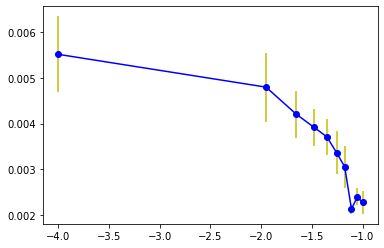

In [32]:
plt.errorbar(np.log10(alphas),
             np.mean(y_err_hist, axis=1),
             yerr=np.std(y_err_hist, axis=1),
             fmt='o-', ecolor='y', color='b')
print(np.linspace(1e-4, 1e-1, 10))


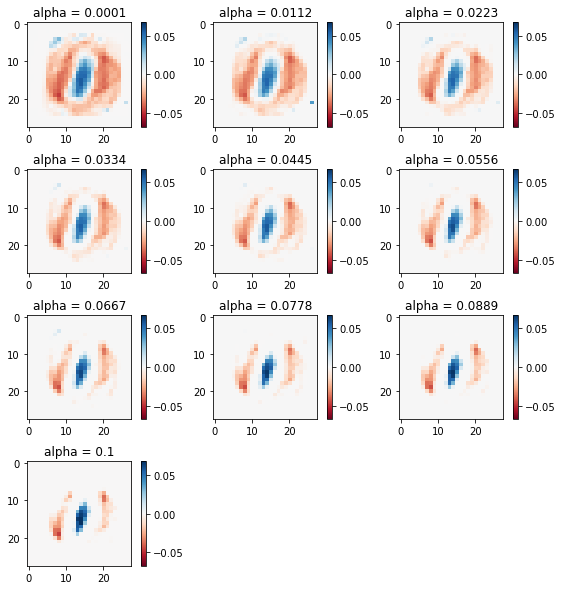

In [33]:
thetas = np.mean(theta_hist, axis = 1)
alphas = np.linspace(1e-4, 1e-1, 10)
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace = 0, hspace = 0.4)
for i, theta in enumerate(thetas):
    plt.subplot(4, 3, i+1)
    scale = np.abs(clf.coef_).max()
    plt.imshow(theta.reshape((28,28)), cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
    plt.title(f"alpha = {round(alphas[i],5)}")
    plt.colorbar()
plt.show()